In [2]:
"""Importing Modules"""
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import os
import shutil
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL.ExifTags import TAGS, GPSTAGS
%matplotlib inline

"""Registering image extensions"""
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
    for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions


In [ ]:
data_dir = '/Users/home/data/'
"""Read in dataframe containing location, rainfall and gps coordinates"""
location_df = pd.read_csv(data_dir + 'gps_coordinates.csv', header=None,
                         index_col=0)
location_df.index.name = 'location'
location_df.columns = ['lat', 'long', 'rainfall']

In [3]:
"""Creating dictionary of pictures in directory structure where directory name is location picture was taken"""
def get_pic_dict(base_path):
    pict_dict = {}
    location = []
    pictures = []
    
    """getting locations"""
    for directory in os.listdir(base_path):
        if os.path.isdir(base_path + directory):
            location.append(directory)
    """adding all pictures in each location to dictionary"""
    for loc in location:
        path = str(base_path + loc + '/')
        pictures = os.listdir(base_path + loc + '/')
        pictures = [path + x for x in pictures]
        pict_dict[loc] = pictures
    
    return pict_dict

pict_dict = get_pic_dict(data_dir + 'pics/') 

/Users/admin_will/Documents/will/ano_mar/data/pics/named_photos/baillif/
/Users/admin_will/Documents/will/ano_mar/data/pics/named_photos/bombo/
/Users/admin_will/Documents/will/ano_mar/data/pics/named_photos/botanical_garden_D23/
/Users/admin_will/Documents/will/ano_mar/data/pics/named_photos/botanical_garden_D23_2_km_E/
/Users/admin_will/Documents/will/ano_mar/data/pics/named_photos/bouillante_1-5_km_S/
/Users/admin_will/Documents/will/ano_mar/data/pics/named_photos/bouillante_2-5_km_N/
/Users/admin_will/Documents/will/ano_mar/data/pics/named_photos/desvarieux/
/Users/admin_will/Documents/will/ano_mar/data/pics/named_photos/grand_etang/
/Users/admin_will/Documents/will/ano_mar/data/pics/named_photos/ilets_pigeon/
/Users/admin_will/Documents/will/ano_mar/data/pics/named_photos/malendure/
/Users/admin_will/Documents/will/ano_mar/data/pics/named_photos/plage_de_clugny/
/Users/admin_will/Documents/will/ano_mar/data/pics/named_photos/st_marie/


In [4]:
"""Takes color image and classifies pixel based on pixel color as part of canopy cover eg. leaf or branch, or as sky eg. cloud, sun, blue sky.
Returns an image that is black and white for further processing, with black as canopy, and white as sky"""
def get_black_n_white(pic_dict):
    """make paths"""
    for i in pict_dict:
        if not os.path.exists(data_dir + 'pics/black_n_white/' + i):
            os.makedirs(data_dir + '/pics/black_n_white/' + i)
    """Open image"""
    for i in pict_dict:
        for j in pict_dict[i]:
            im = Image.open(j)
            working_image = im.copy()
            width, height = working_image.size
            has_alpha = working_image.mode == 'RGBA'
            
            """change the pixels"""
            for x in range(width):
                for y in range(height):
                    r, g, b = working_image.getpixel((x,y))
                    new_color = (r, g, b)
                    """Gets dark branches"""
                    if (g + b + r) < 100:
                        r, g, b = (0, 0, 0)

                    """picks up some ligher blue skies"""
                    if g > 0 and r > 0 and (g + b + r) > 225:
                        if b / g > 1 and b / r > 1:
                            r, g, b = (255, 255, 255)

                    """picks up definitive green leaves and some branches"""
                    if g > (b + 10) and r > (b + 10):
                        r, g, b = (0, 0, 0)

                    """removes lighter blues, but maybe some greens as well"""
                    if b > 100:
                        r, g, b = (255, 255, 255)

                    """Removing Darker Blues"""
                    if b < 100 and b > (g + 6):
                        r, g, b, = (255, 255, 255)

                    """Take anything that is lightish left and turn to white, then turn the rest black"""
                    if (g + b + r) > 200:
                        r, g, b, = (255, 255, 255)
                    else:
                        r, g, b, = (0, 0, 0)
                    """Put the final pixel colors into new_color and then into the x,y coordinates.  Save picture"""
                    new_color = (r, g, b) 
                    working_image.putpixel((x,y), new_color)

            """Saving image"""        
            name = os.path.basename(j)        
            print(name)
            working_image.save(data_dir + '/pics/black_n_white/' + i + '/black_' + name)      
            print(j)
            
get_black_n_white(pict_dict)


'Dont run again'

In [6]:
"""Definine functions to retrieve exif data from each picture as well as latitude and longitude"""
def get_exif_data(image):
    """Returns a dictionary from the exif data of an PIL Image item. Also converts the GPS Tags"""
    exif_data = {}
    info = image._getexif()
    if info:
        for tag, value in info.items():
            decoded = TAGS.get(tag, tag)
            if decoded == "GPSInfo":
                gps_data = {}
                for t in value:
                    sub_decoded = GPSTAGS.get(t, t)
                    gps_data[sub_decoded] = value[t]

                exif_data[decoded] = gps_data
            else:
                exif_data[decoded] = value

    return exif_data

def _convert_to_degress(value):
    """Helper function to convert the GPS coordinates stored in the EXIF to degress in float format"""
    d0 = value[0][0]
    d1 = value[0][1]
    d = float(d0) / float(d1)

    m0 = value[1][0]
    m1 = value[1][1]
    m = float(m0) / float(m1)

    s0 = value[2][0]
    s1 = value[2][1]
    s = float(s0) / float(s1)

    return d + (m / 60.0) + (s / 3600.0)

def _get_if_exist(data, key):
    if key in data:
        return data[key]
    
def get_lat_lon(exif_data):
    """Returns the latitude and longitude, if available, from the provided exif_data (obtained through get_exif_data above)"""
    lat = None
    lon = None

    if "GPSInfo" in exif_data:		
        gps_info = exif_data["GPSInfo"]

        gps_latitude = _get_if_exist(gps_info, "GPSLatitude")
        gps_latitude_ref = _get_if_exist(gps_info, 'GPSLatitudeRef')
        gps_longitude = _get_if_exist(gps_info, 'GPSLongitude')
        gps_longitude_ref = _get_if_exist(gps_info, 'GPSLongitudeRef')

        if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
            lat = _convert_to_degress(gps_latitude)
            if gps_latitude_ref != "N":                     
                lat = 0 - lat

            lon = _convert_to_degress(gps_longitude)
            if gps_longitude_ref != "E":
                lon = 0 - lon

    return lat, lon

In [7]:
"""Counts the number of black pixels in black and white pictures as a representation of canopy cover within that picture.  Returns data frame with 
counts and lat and lon data"""

def get_count_black(pic_dict):
    """making df of picture data"""
    pic_df = pd.DataFrame(columns = ['location', 'pic', 'total_pixels', 'black_pixels', 'lat', 'lon'] )
#     pic_df.columns = ['location', 'pic', 'total_pixels', 'black_pixels']
    loc = 0
    import scipy.ndimage
    """get paths"""
    for i in pict_dict:
        for j in pict_dict[i]:
            basename = os.path.basename(j)
            """Get lat, lon from original image"""
            orig_im = Image.open(j)
            lat, lon = get_lat_lon(get_exif_data(orig_im))
            
            """Get black and white image and count black pixels"""
            file_path = str('/Users/admin_will/Documents/will/ano_mar/data/pics/black_n_white/' + i + '/black_' + basename)
            print(basename)
            pil_im = Image.open(file_path).copy()
            width, height = pil_im.size
            total = width * height 
            numpy_im = scipy.ndimage.imread(file_path)
            white = numpy_im.any(axis=-1).sum()
            black = total - white
            pic_df.loc[loc] = [i, basename, total, black, lat, lon]
            loc += 1
            
    return pic_df

        
pic_df = get_count_black(pict_dict)


baillif_000.jpg


/Users/admin_will/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


baillif_001.jpg
baillif_002.jpg
baillif_003.jpg
baillif_004.jpg
baillif_005.jpg
bombo_000.jpg
bombo_001.jpg
bombo_002.jpg
bombo_003.jpg
bombo_004.jpg
bombo_005.jpg
bombo_006.jpg
bombo_007.jpg
bombo_008.jpg
botanical_garden_D23_000.jpg
botanical_garden_D23_001.jpg
botanical_garden_D23_002.jpg
botanical_garden_D23_003.jpg
botanical_garden_D23_004.jpg
botanical_garden_D23_005.jpg
botanical_garden_D23_006.jpg
botanical_garden_D23_2_km_E_000.jpg
botanical_garden_D23_2_km_E_001.jpg
botanical_garden_D23_2_km_E_0010.jpg
botanical_garden_D23_2_km_E_002.jpg
botanical_garden_D23_2_km_E_003.jpg
botanical_garden_D23_2_km_E_004.jpg
botanical_garden_D23_2_km_E_005.jpg
botanical_garden_D23_2_km_E_006.jpg
botanical_garden_D23_2_km_E_007.jpg
botanical_garden_D23_2_km_E_008.jpg
botanical_garden_D23_2_km_E_009.jpg
bouillante_1-5_km_S_000.jpg
bouillante_1-5_km_S_001.jpg
bouillante_1-5_km_S_002.jpg
bouillante_1-5_km_S_003.jpg
bouillante_1-5_km_S_004.jpg
bouillante_2-5_km_N_000.jpg
bouillante_2-5_km_N_001.jp

'TO DO\nset up dictionary where count data will be stored\nmaybe should be dataframe\nneed to include location, pic name, total pixels, black pixels\nadd count data to df \nwrite function to run \nrun get gis data on all pics\n'

In [10]:
"""Adding in columns to data frame for vizualizing percent canopy cover across the range of images"""
pic_df['diff'] = 0
pic_df.sort_values(by=['location', 'black_pixels'], inplace=True)

"""Gets number of pixels different between total column and black column"""
pic_df['diff'] = pic_df['black_pixels'].diff()

"""filling accross for the start of each location"""
pic_df.loc[pic_df['diff'] < 0, 'diff'] = pic_df['black_pixels']
pic_df['diff_ratio'] = pic_df['diff'] / pic_df['total_pixels']
pic_df.reset_index(drop=True, inplace=True)

"""adding in percentage canopy to get mean"""
pic_df['percentage'] = pic_df['black_pixels'] / pic_df['total_pixels']
pic_df['percentage'] = pic_df['percentage'].astype(float)


baillif


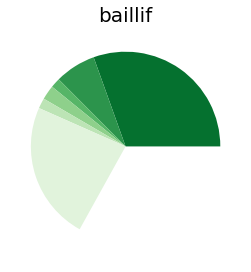

bombo


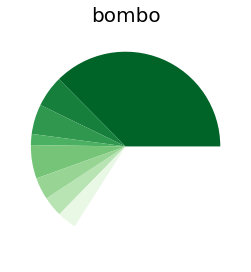

botanical_garden_D23


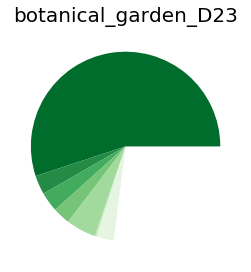

botanical_garden_D23_2_km_E


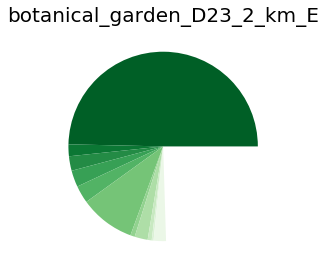

bouillante_1-5_km_S


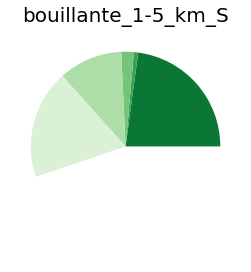

bouillante_2-5_km_N


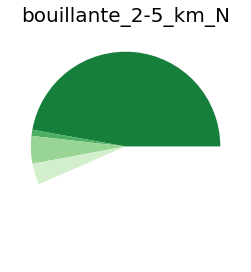

desvarieux


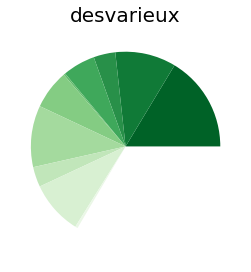

grand_etang


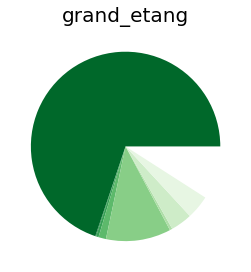

ilets_pigeon


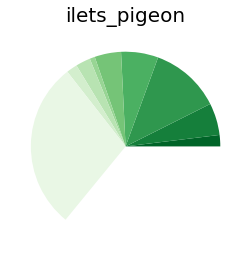

malendure


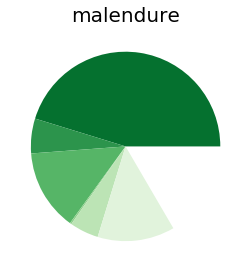

plage_de_clugny


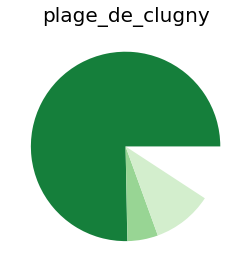

st_marie


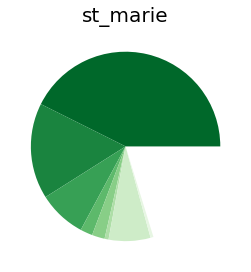

In [14]:
"""Generate Pie Charts displaying minimum and maximum canopy cover for each location, with intermediate canopy cover values displayed as well"""
plt.style.use("fivethirtyeight")
sns.set_style()
from matplotlib.colors import ListedColormap
for locat in pic_df['location'].unique():
    length= pic_df[pic_df['location'] == locat]['location'].shape[0]
    color_idx = np.linspace(0, 1, length)
    my_cmap = ListedColormap(sns.color_palette('Greens_r', n_colors=length))
    colors = my_cmap(color_idx)
    explode = np.zeros(length)
    canopy = pic_df[pic_df['location'] == locat]['diff_ratio']
    
    print(locat)
    fig1, ax1 = plt.subplots()
    plt.rcParams['patch.linewidth'] = 0
    plt.rcParams['patch.edgecolor'] = 'none'
    ax1.pie(canopy, colors=colors, explode=explode)
    plt.title(locat, fontsize=20)
    fig1.patch.set_facecolor('xkcd:white')
    plt.tight_layout()
    plt.savefig(data_dir + 'pics/figures/' + locat + '_canopy_cover.png')
    plt.show()

In [11]:
# plt.style.available

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 0 to 92
Data columns (total 7 columns):
location        87 non-null object
pic             87 non-null object
total_pixels    87 non-null object
black_pixels    87 non-null object
diff            87 non-null object
diff_ratio      87 non-null object
percentage      87 non-null float64
dtypes: float64(1), object(6)
memory usage: 5.4+ KB


/Users/admin_will/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


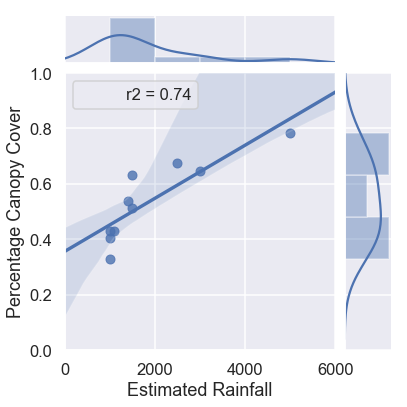

In [14]:
"""Plotting regression line for canopy cover vs rainfall
Quick Seaborn plot, no extras"""
sns.set(style='darkgrid', context='talk')
environment_df = location_df.merge(pd.DataFrame(pic_df[['location', 'percentage']].groupby('location').mean()), 
                                   left_index=True, right_index=True)
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
regression = sns.jointplot(x='rainfall', y='percentage', kind="reg", data=ev_df.reset_index(), stat_func=r2)

plt.ylim(0,1)
plt.xlim(0,6000)
plt.ylabel('Percentage Canopy Cover')
plt.xlabel('Estimated Rainfall')
plt.savefig(data_dir + 'pics/figures/canopy_v_rainfall.png')